In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings("ignore", category=UnicodeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/1Uaj-eE2SNav93r_dQDGUYsDnFeUK9rt1/view?usp=drive_link"

direct_link = get_direct_link(link)
df = pd.read_csv(direct_link, encoding='utf-8')

In [3]:
train_df = df[~(df['date'] > '2019-01-00')].copy()
test_df = df[(df['date'] > '2019-01-00')].copy()

test_df.reset_index(inplace=True)
print('Fit set rows: ' + str(len(train_df)))
print('Test set rows: ' + str(len(test_df)))

Fit set rows: 15854
Test set rows: 5190


# Hercog

In [4]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(rank=True, wiki=True):
    features = ['inverse_avg']
    if rank:
        features.append('rankdist')
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, rankdist=None, wikibuzz=None):
    prob = coef[0] + coef[1] * inv_odds  
    if rankdist is not None:
        prob += coef[2] * rankdist
    if wikibuzz is not None:
        prob += coef[-1] * wikibuzz
    return prob

def kelly(implied_prob, predicted_prob):
    return max(predicted_prob - ((1 - predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else -stake

def estimate_probabilities(test_data, coef, odds_provider, use_rank=True, use_wiki=True):
    if use_rank and use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], row['rankdist'], row['wikibuzz']), axis=1)
    elif use_rank:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], rankdist=row['rankdist']), axis=1)
    elif use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], wikibuzz=row['wikibuzz']), axis=1)
    else:
        test_data['est_prob'] = test_data['inverse_avg'].apply(lambda x: model_prob(coef, x))

    return test_data

def display_results(test_data, odds_provider):
    bet_considered = len(test_data[test_data[f'inverse_{odds_provider}'].notna()])
    bets_placed = len(test_data.loc[(test_data["profit"].notna()) & (test_data["profit"] != 0)])
    mean_overround = ((test_data.sort_values(by="match_id")[f"inverse_{odds_provider}"].rolling(2).sum().iloc[1::2].mean() - 1) * 100)
    total_stake = test_data['stake'].sum()
    total_return = test_data['profit'].sum()
    roi = (((total_return + total_stake) / total_stake) - 1) * 100
    
    results = {
        'Bets considered (2 * Matches)': bet_considered,
        'Number of bets placed': bets_placed,
        'Mean overround (%)': mean_overround,
        'Absolute amount bet': total_stake,
        'Absolute return': total_return,
        'ROI (%)': roi
    }
    
    return results

def show_results(test_data, coef, odds_provider, rank=True, wiki=True):
    test_data = estimate_probabilities(test_data, coef, odds_provider, rank, wiki)
    test_data['stake'] = [kelly(a, b) for a, b in zip(test_data[f'inverse_{odds_provider}'], test_data['est_prob'])]
    test_data['profit'] = [profit(a, b, c) for a, b, c in zip(test_data['stake'], test_data[f'inverse_{odds_provider}'], test_data['outcome'])]
    
    results = display_results(test_data, odds_provider)
    print(results)
    return results

def plot_results(test_df):
    test_df['cum_profit'] = test_df['profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


{'Bets considered (2 * Matches)': 5156, 'Number of bets placed': 312, 'Mean overround (%)': 6.4564991249188575, 'Absolute amount bet': 7.151004389194398, 'Absolute return': 1.2360930817859346, 'ROI (%)': 17.285586954103206}


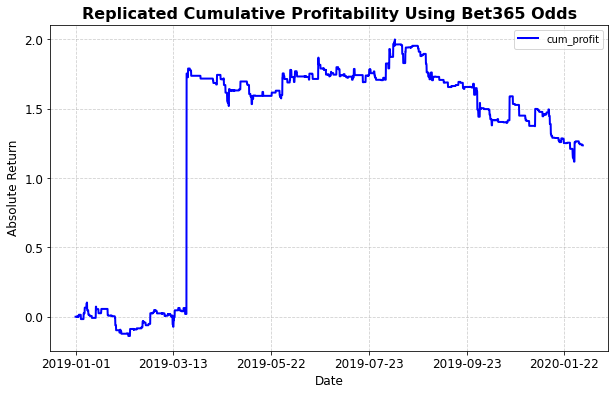

In [5]:
# preferred model on B365
coef = train_model()
show_results(test_df, coef, 'B365')
plot_results_save(test_df, 'hercog1.png', "Replicated Cumulative Profitability Using Bet365 Odds")


In [6]:
test_df.sort_values(by=['profit'], ascending=False)

,index,match_id,player,date,year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,cum_profit
1135,16989,5883,Hercog P.,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.497091,0.385334,1.734001,1.754114
4439,20293,20000,Kudermetova V.,2019-10-17,2019.0,0.226190,1.707976,0.307692,0.364964,0.307692,1,0.360454,0.076212,0.171476,1.588135
2482,18336,12033,Putintseva Y.,2019-06-20,2019.0,0.976744,1.032863,0.266667,0.279330,0.250000,1,0.307616,0.055840,0.153559,1.868708
5104,20958,2540,Kenin S.,2020-01-30,2020.0,0.933333,1.061726,0.266667,0.277778,0.248139,1,0.303912,0.050789,0.139668,1.258309
3209,19063,15953,Kenin S.,2019-08-06,2019.0,0.965517,0.797335,0.230947,0.238663,0.217391,1,0.263184,0.041918,0.139587,1.930825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,20163,19911,Voegele S.,2019-10-08,2019.0,0.001515,-3.183785,NaN,0.291545,0.250000,0,0.228672,NaN,NaN,NaN
4410,20264,19978,Mertens E.,2019-10-15,2019.0,-0.046262,0.199227,NaN,0.952381,0.943396,1,0.934090,NaN,NaN,NaN
4413,20267,19978,Schoofs B.,2019-10-15,2019.0,0.046262,-0.199227,NaN,0.081301,0.040000,0,0.042577,NaN,NaN,NaN
4789,20643,2387,Zhang S.,2020-01-14,2020.0,-0.012342,0.273696,NaN,0.666667,0.495050,1,0.643724,NaN,NaN,NaN


In [7]:
test_df.loc[test_df.match_id==5883]

,index,match_id,player,date,year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,cum_profit
1135,16989,5883,Hercog P.,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.497091,0.385334,1.734001,1.754114
1141,16995,5883,Doi M.,2019-03-23,2019.0,0.001824,1.707411,0.877193,0.495050,0.421941,0,0.481532,0.000000,-0.000000,1.754114


{'Bets considered (2 * Matches)': 5156, 'Number of bets placed': 276, 'Mean overround (%)': 6.4564991249188575, 'Absolute amount bet': 4.987843280939489, 'Absolute return': 1.4372911056210453, 'ROI (%)': 28.815883432294264}


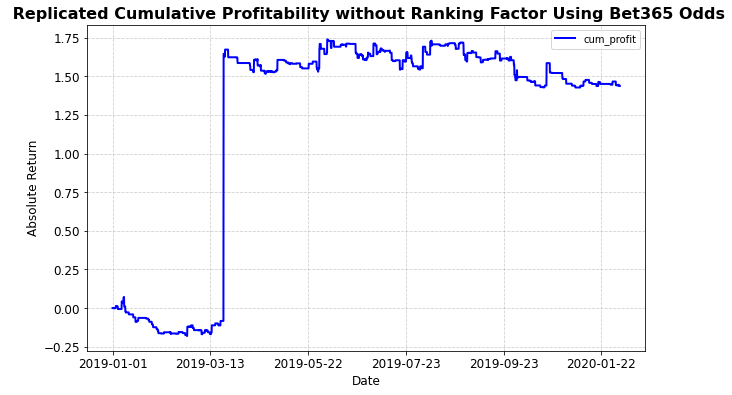

In [8]:
coef = train_model(rank=False)
show_results(test_df, coef, 'B365', rank=False)
plot_results_save(test_df, 'hercog2.png', " Replicated Cumulative Profitability without Ranking Factor Using Bet365 Odds")

In [9]:
test_df.sort_values(by=['profit'], ascending=False)

,index,match_id,player,date,year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,cum_profit
1135,16989,5883,Hercog P.,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.495942,0.383929,1.727679,1.644673
4439,20293,20000,Kudermetova V.,2019-10-17,2019.0,0.226190,1.707976,0.307692,0.364964,0.307692,1,0.352341,0.064492,0.145107,1.584685
3174,19028,15940,Di Lorenzo F.,2019-08-05,2019.0,0.041040,3.427324,0.230947,0.259740,0.222222,1,0.263127,0.041844,0.139341,1.690879
2115,17969,10071,Bolsova A.,2019-05-27,2019.0,0.005521,4.553877,0.500000,0.546448,0.487805,1,0.562174,0.124348,0.124348,1.673876
3249,19103,15975,Andreescu B.,2019-08-08,2019.0,0.162963,3.861998,0.333333,0.353357,0.319489,1,0.361416,0.042125,0.084249,1.724004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,20163,19911,Voegele S.,2019-10-08,2019.0,0.001515,-3.183785,NaN,0.291545,0.250000,0,0.231435,NaN,NaN,NaN
4410,20264,19978,Mertens E.,2019-10-15,2019.0,-0.046262,0.199227,NaN,0.952381,0.943396,1,0.928284,NaN,NaN,NaN
4413,20267,19978,Schoofs B.,2019-10-15,2019.0,0.046262,-0.199227,NaN,0.081301,0.040000,0,0.048838,NaN,NaN,NaN
4789,20643,2387,Zhang S.,2020-01-14,2020.0,-0.012342,0.273696,NaN,0.666667,0.495050,1,0.641801,NaN,NaN,NaN


In [10]:
test_df.loc[test_df.match_id==5883]

,index,match_id,player,date,year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,cum_profit
1135,16989,5883,Hercog P.,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.495942,0.383929,1.727679,1.644673
1141,16995,5883,Doi M.,2019-03-23,2019.0,0.001824,1.707411,0.877193,0.495050,0.421941,0,0.483098,0.000000,-0.000000,1.644673


{'Bets considered (2 * Matches)': 5155, 'Number of bets placed': 311, 'Mean overround (%)': 6.466222358689899, 'Absolute amount bet': 6.765670748001687, 'Absolute return': -0.49790830358126403, 'ROI (%)': -7.359333939333757}


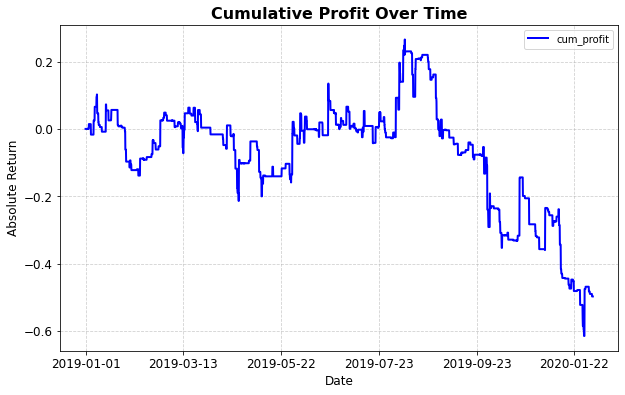

[-0.0414954   1.02512999  0.05469513  0.00904175]


In [11]:
test_df.drop(index=1135, inplace=True)
coef = train_model()
show_results(test_df, coef, 'B365')
plot_results(test_df)
print(coef)

{'Bets considered (2 * Matches)': 5155, 'Number of bets placed': 275, 'Mean overround (%)': 6.466222358689899, 'Absolute amount bet': 4.603914720143379, 'Absolute return': -0.2903874179614515, 'ROI (%)': -6.307402191681078}


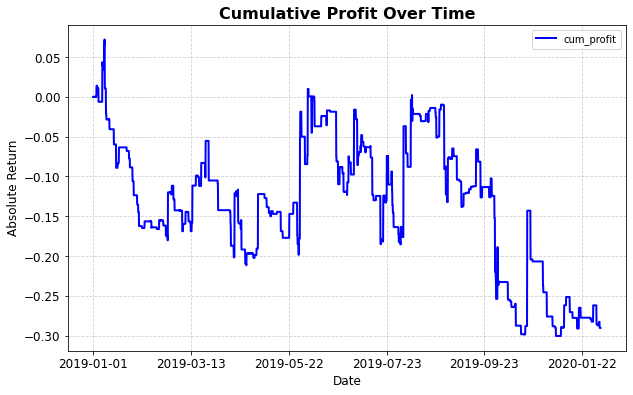

[-0.03096748  1.00519909  0.00962968]


In [12]:
coef = train_model(rank=False)
show_results(test_df, coef, 'B365', rank=False)
plot_results(test_df)
print(coef)

# Kelly - B365

In [13]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(rank=True, wiki=True):
    features = ['inverse_avg']
    if rank:
        features.append('rankdist')
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, rankdist=None, wikibuzz=None):
    prob = coef[0] + coef[1] * inv_odds  
    if rankdist is not None:
        prob += coef[2] * rankdist
    if wikibuzz is not None:
        prob += coef[-1] * wikibuzz
    return prob

def kelly(implied_prob, predicted_prob):
    return max(predicted_prob - ((1 - predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else -stake

def estimate_probabilities(test_data, coef, odds_provider, use_rank=True, use_wiki=True):
    if use_rank and use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], row['rankdist'], row['wikibuzz']), axis=1)
    elif use_rank:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], rankdist=row['rankdist']), axis=1)
    elif use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], wikibuzz=row['wikibuzz']), axis=1)
    else:
        test_data['est_prob'] = test_data['inverse_avg'].apply(lambda x: model_prob(coef, x))

    return test_data

def display_results(test_data, odds_provider):
    bet_considered = len(test_data[test_data[f'inverse_{odds_provider}'].notna()])
    bets_placed = len(test_data.loc[(test_data["correct_profit"].notna()) & (test_data["correct_profit"] != 0)])
    mean_overround = ((test_data.sort_values(by="match_id")[f"inverse_{odds_provider}"].rolling(2).sum().iloc[1::2].mean() - 1) * 100)
    total_stake = test_data['correct_stake'].sum()
    total_return = test_data['correct_profit'].sum()
    roi = (((total_return + total_stake) / total_stake) - 1) * 100
    
    results = {
        'Bets considered (2 * Matches)': bet_considered,
        'Number of bets placed': bets_placed,
        'Mean overround (%)': mean_overround,
        'Absolute amount bet': total_stake,
        'Absolute return': total_return,
        'ROI (%)': roi
    }
    
    return results

def show_results(test_data, coef, odds_provider, rank=True, wiki=True):
    test_data = estimate_probabilities(test_data, coef, odds_provider, rank, wiki)
    test_data['stake'] = [kelly(a, b) for a, b in zip(test_data[f'inverse_{odds_provider}'], test_data['est_prob'])]
    test_data['profit'] = [profit(a, b, c) for a, b, c in zip(test_data['stake'], test_data[f'inverse_{odds_provider}'], test_data['outcome'])]
    
    test_df['original_stake'] = [kelly(a,b) for a,b in zip(test_df['inverse_{}'.format(odds_provider)], test_df['est_prob'])]
    test_df['original_profit'] = [profit(a,b,c) for a,b,c in zip(test_df['original_stake'],test_df['inverse_{}'.format(odds_provider)],test_df['outcome'])]
    test_df['post-bet_balance'] = (test_df['original_profit'] + 1).cumprod()
    test_df['pre-bet_balance'] = test_df['post-bet_balance'].shift(1)
    test_df['correct_stake'] = test_df['original_stake'] * test_df['pre-bet_balance']
    test_df['correct_profit'] = test_df['original_profit'] * test_df['pre-bet_balance']
    
    results = display_results(test_data, odds_provider)
    print(results)
    return results

def plot_results(test_df):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


{'Bets considered (2 * Matches)': 5155, 'Number of bets placed': 311, 'Mean overround (%)': 6.466222358689899, 'Absolute amount bet': 5.875868090917189, 'Absolute return': -0.4984130321199458, 'ROI (%)': -8.48237272191974}


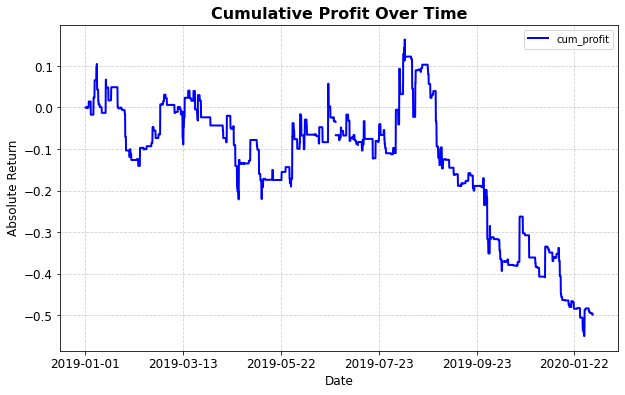

In [14]:
# PM on Bet365
coef = train_model()
show_results(test_df, coef, 'B365')
plot_results(test_df)

{'Bets considered (2 * Matches)': 5155, 'Number of bets placed': 274, 'Mean overround (%)': 6.466222358689899, 'Absolute amount bet': 3.942731583179085, 'Absolute return': -0.3230268277377436, 'ROI (%)': -8.192970303022307}


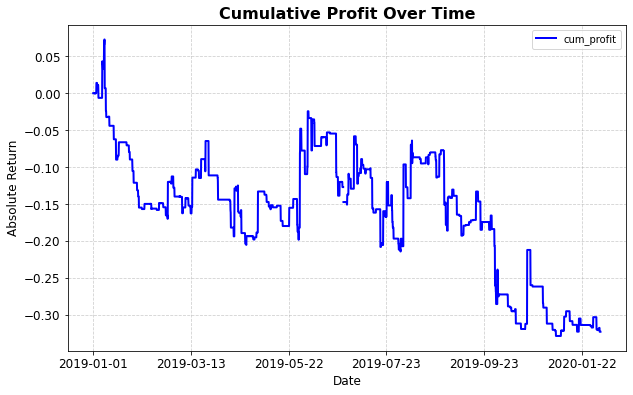

In [15]:
# PM w/o rank on Bet365
coef = train_model(rank=False)
show_results(test_df, coef, 'B365', rank=False)
plot_results(test_df)

# Kelly for Best
We do not remove the Hercog bet as this is not an anomaly for the 'Best' odds

In [16]:
train_df = df[~(df['date'] > '2019-01-00')].copy()
test_df = df[(df['date'] > '2019-01-00')].copy()

test_df.reset_index(inplace=True)
print('Fit set rows: ' + str(len(train_df)))
print('Test set rows: ' + str(len(test_df)))

Fit set rows: 15854
Test set rows: 5190


{'Bets considered (2 * Matches)': 5189, 'Number of bets placed': 2350, 'Mean overround (%)': -0.2277009070871583, 'Absolute amount bet': 120.89880524110254, 'Absolute return': -0.2730959482192956, 'ROI (%)': -0.22588804552259312}


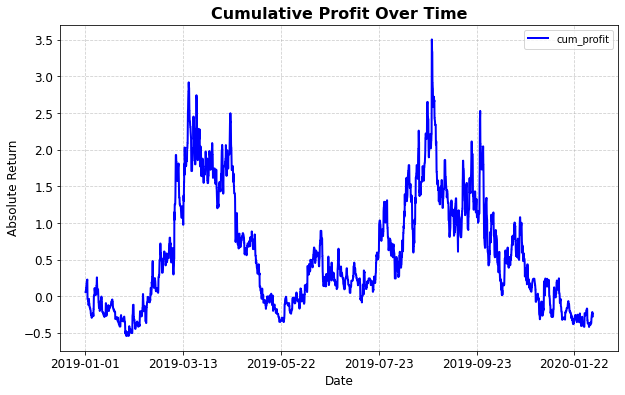

In [17]:
coef = train_model()
show_results(test_df, coef, 'best')
plot_results(test_df)

{'Bets considered (2 * Matches)': 5189, 'Number of bets placed': 2351, 'Mean overround (%)': -0.2277009070871583, 'Absolute amount bet': 57.961111125876265, 'Absolute return': -0.4282778183242862, 'ROI (%)': -0.7389054661049888}


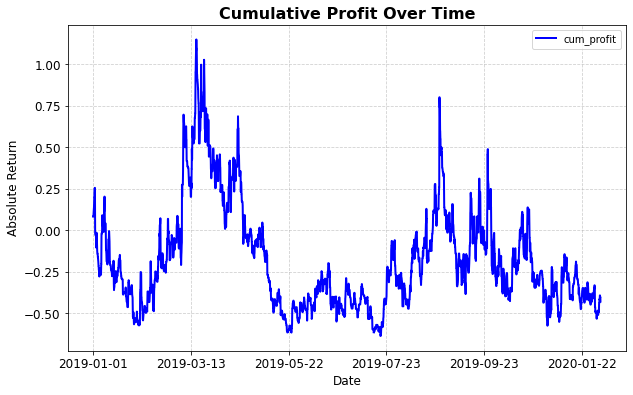

In [18]:
coef = train_model(rank=False)
show_results(test_df, coef, 'best', rank =False)
plot_results(test_df)

{'Bets considered (2 * Matches)': 5189, 'Number of bets placed': 2009, 'Mean overround (%)': -0.2277009070871583, 'Absolute amount bet': 40.273460742174954, 'Absolute return': -0.49196723718514845, 'ROI (%)': -1.2215668286732484}


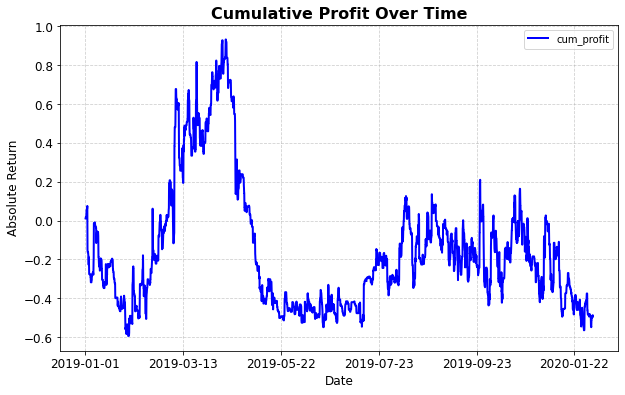

In [19]:
coef = train_model(wiki=False)
show_results(test_df, coef, 'best', wiki =False)
plot_results(test_df)

{'Bets considered (2 * Matches)': 5189, 'Number of bets placed': 2036, 'Mean overround (%)': -0.2277009070871583, 'Absolute amount bet': 17.35017478064578, 'Absolute return': -0.5826501626420527, 'ROI (%)': -3.3581803642232066}


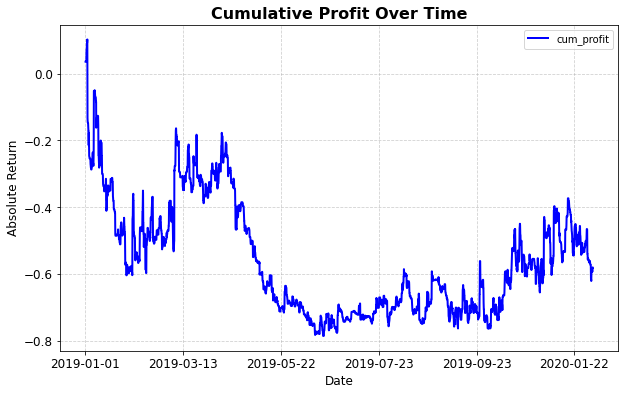

In [20]:
coef = train_model(rank=False, wiki = False)
show_results(test_df, coef, 'best', rank =False, wiki = False)
plot_results(test_df)